In [1]:
import numpy as np
import scipy
import scipy.stats
import pandas as pd
import astropy.units as u
import sunpy.map
import sunpy.visualization.colormaps as cm
import cv2
import skimage
import glob
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import random

import matplotlib.pyplot as plt
import seaborn as sns
import seaborn_image as isns
sns.set_style("darkgrid")

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from keras import layers

tf.distribute.MirroredStrategy()


import autoenc_model as aem
import data_generator as dg
import utils

2023-04-16 16:18:36.826358: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


2023-04-16 16:18:38.343350: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 16:18:38.469460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-16 16:18:38.469561: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [2]:
batch_size = 32
gen_input = dg.SunImgAE3CGenerator("data/composite_data/", batch_size, test_split=0.2, shuffle=True, noise_filter=True)

/home/eugeniolr/Documents/master/TFM/data_generator.py:107: RuntimeWarning: All-NaN slice encountered
  min_values = np.nanmin(np.nanmin(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:108: RuntimeWarning: All-NaN slice encountered
  max_values = np.nanmax(np.nanmax(data_matrix, axis=2, keepdims=True), axis=1, keepdims=True)
/home/eugeniolr/Documents/master/TFM/data_generator.py:116: RuntimeWarning: All-NaN slice encountered
  hmi_max_values = np.nanmax(np.nanmax(np.abs(data_matrix[:,:,:,2]), axis=2, keepdims=True), axis=1, keepdims=True)


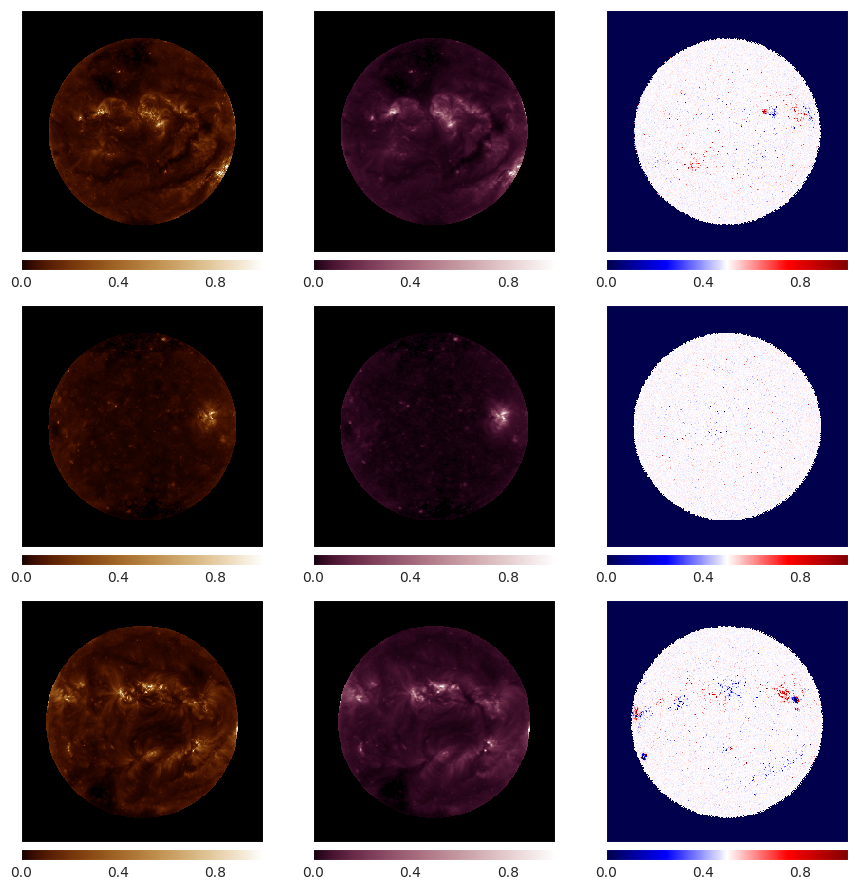

In [3]:
img_amount = 3

sample_images = gen_input.sample(img_amount)

image_list = []
for data_image in sample_images:
    for channel in data_image.transpose(2,0,1):
        image_list.append(channel)

isns.ImageGrid(image_list, cmap=["sdoaia193", "sdoaia211", "seismic"]*img_amount, orientation="h", vmin=0, vmax=1)


In [4]:
latent_size = 64
# optimizer = keras.optimizers.Adam(learning_rate=0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.01)
optimizer = keras.optimizers.RMSprop(learning_rate=0.001)

loss_fn = "mse"

autoencoder, encoder, decoder = aem.gen_xception_autoenc_3c(latent_size, optim=optimizer, loss=loss_fn)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [5]:
n_epochs = 125

history = autoencoder.fit(gen_input, epochs=n_epochs)

Epoch 1/125


2023-04-16 16:18:41.463305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-16 16:18:45.623225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800
2023-04-16 16:18:47.414909: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


562/562 [==============================] - 120s 197ms/step - loss: 0.0210 - mae: 0.0617
Epoch 2/125
562/562 [==============================] - 91s 161ms/step - loss: 0.0198 - mae: 0.0548
Epoch 3/125
562/562 [==============================] - 90s 160ms/step - loss: 0.0197 - mae: 0.0536
Epoch 4/125
562/562 [==============================] - 92s 163ms/step - loss: 0.0196 - mae: 0.0532
Epoch 5/125
562/562 [==============================] - 92s 163ms/step - loss: 0.0192 - mae: 0.0502
Epoch 6/125
562/562 [==============================] - 92s 163ms/step - loss: 0.0191 - mae: 0.0494
Epoch 7/125
562/562 [==============================] - 93s 166ms/step - loss: 0.0192 - mae: 0.0497
Epoch 8/125
562/562 [==============================] - 94s 167ms/step - loss: 0.0190 - mae: 0.0493
Epoch 9/125
562/562 [==============================] - 93s 164ms/step - loss: 0.0189 - mae: 0.0485
Epoch 10/125
562/562 [==============================] - 94s 167ms/step - loss: 0.0189 - mae: 0.0482
Epoch 11/125
562/562

In [6]:
autoencoder.save("autoencoder_xception.h5")
encoder.save("encoder_xception.h5")
decoder.save("decoder_xception.h5")

2023-04-16 19:36:02.009199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


562/562 [==============================] - 95s 169ms/step - loss: 9.8106e-04 - mae: 0.0098


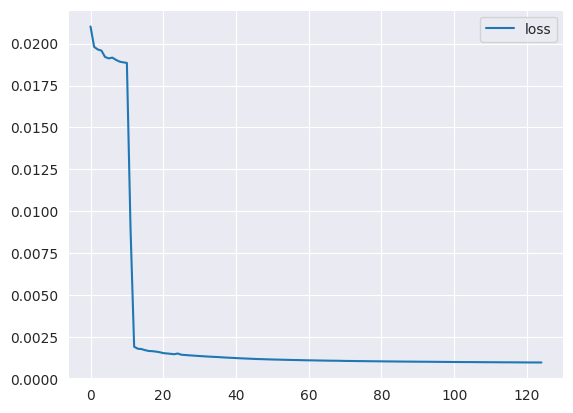

In [7]:
gen_input.training = False
autoencoder.evaluate(gen_input)
plt.plot(history.history['loss'], label='loss')
# plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

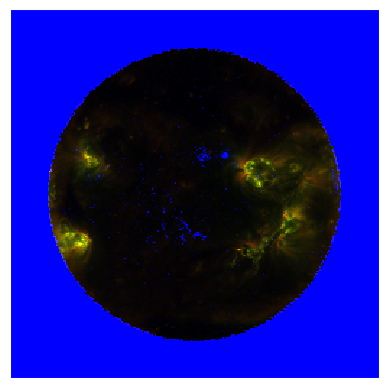

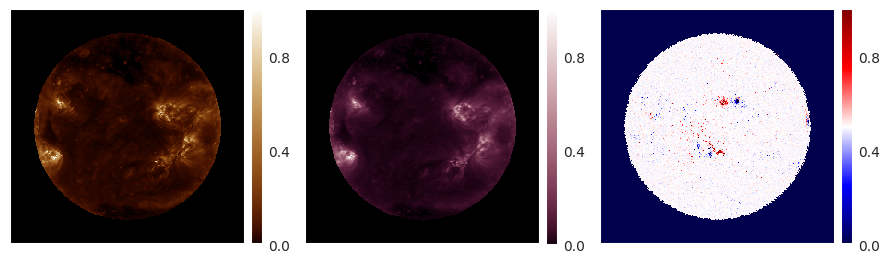

In [111]:
# test_img = np.array(random.choices(input_test, k=1))
test_img = gen_input.sample(1)

test_img_display = test_img[0].copy()
test_img_display[:,:,2] = np.abs((0.5 - test_img_display[:,:,2])*2)
isns.imgplot(test_img_display)
isns.rgbplot(test_img[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)

<AxesSubplot: >

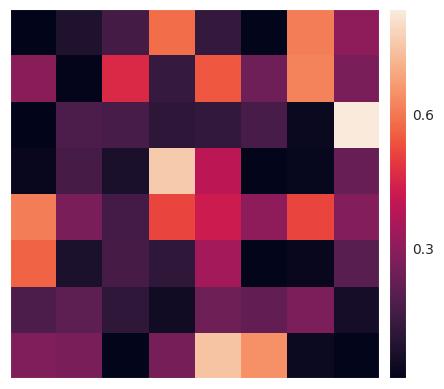

In [112]:
code = encoder(test_img)
# isns.imgplot(np.reshape(code[0], (6, 8)))
isns.imgplot(np.reshape(code[0], (8, 8)))

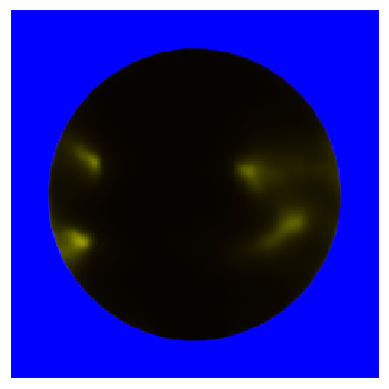

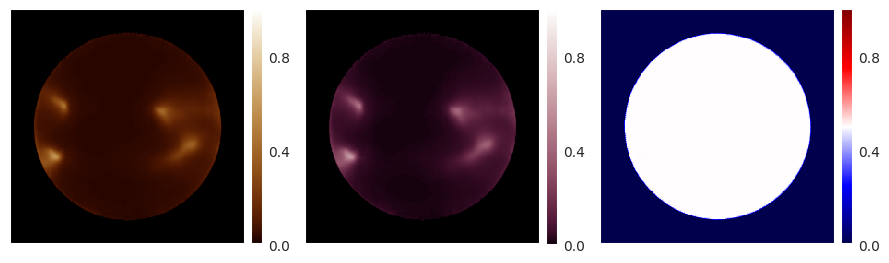

In [113]:
decoded = decoder(code)
decoded_display = np.copy(decoded[0])
decoded_display[:,:,2] = np.abs((0.5 - decoded_display[:,:,2])*2)
isns.imgplot(decoded_display)
isns.rgbplot(decoded[0], cmap=["sdoaia193", "sdoaia211", "seismic"], vmin=0, vmax=1)